# **Final Project: Multi-Agent System (MAS)**

## **✍ Topic: Optimizing PIBT with Utility-Based Agents for Automated Warehouses**

**Group 9:**
* **Arjja Dharma Tjahjo** (1232001052)
* **M. Rafli Pradana** (1232001048)
* **Yohanes Stevandrew** (1232001036)

### **1. 🧐 Project Overview & Background**

Dalam era industri 4.0, efisiensi logistik sangat bergantung pada *Automated Warehouse* (gudang otomatis) di mana ratusan hingga ribuan robot harus bergerak secara simultan untuk memindahkan barang. Tantangan utama dalam domain ini adalah **Multi-Agent Path Finding (MAPF)**, yaitu bagaimana merencanakan jalur bebas tabrakan (*collision-free*) untuk banyak agent dalam waktu nyata (*real-time*).

**Latar Belakang Masalah (Problem Background):**
Kami merujuk pada algoritma **Priority Inheritance with Backtracking (PIBT)** [Okumura et al.] sebagai *baseline*. PIBT dikenal sangat cepat dan terdesentralisasi. Namun, kami menemukan celah fundamental (*research gap*) pada algoritma aslinya:
* **Rigiditas Prioritas:** PIBT standar menggunakan prioritas statis (berdasarkan ID agen atau angka acak).
* **Pengabaian Konteks Fisik:** Algoritma ini tidak memperhitungkan kondisi internal agen, seperti **Battery Level**.
* **Risiko Kegagalan:** Dalam skenario sumber daya terbatas, agen dengan baterai kritis (misal: 5%) seringkali dipaksa mengalah (*wait*) oleh agen dengan baterai penuh yang memiliki ID prioritas lebih tinggi. Hal ini menyebabkan agen kritis tersebut "mati" (*dead agent*) sebelum mencapai *charging station* atau tujuan.

**Solusi yang Diusulkan (Proposed Solution):**
Proyek ini mengimplementasikan inovasi berupa **Utility-Based PIBT**. Kami mengubah mekanisme penentuan prioritas dari statis menjadi dinamis berdasarkan fungsi utilitas:
$$Priority = f(Battery Level, Urgency)$$
Dengan pendekatan ini, *Rational Agent* akan "bernegosiasi" hak jalan berdasarkan urgensi, seperti agent dengan baterai lebih rendah akan secara otomatis mendapatkan prioritas lebih tinggi untuk bergerak.

**Tujuan Proyek (Project Goals):**
Notebook ini bertujuan untuk mensimulasikan lingkungan *Multi-Agent System* tersebut, menghasilkan *dataset* pergerakan agent, dan membuktikan hipotesis bahwa pendekatan *Utility-Based* mampu meningkatkan **Survivability Rate** agent tanpa mengorbankan efisiensi operasional secara signifikan.

### **2. 🛠️ The Design of MAS (Architecture)**

Pada bab ini, kami mendefinisikan arsitektur dari **Multi-Agent System (MAS)** kami. Kami memodelkan robot gudang kami sebagai **Rational Agents** yang beroperasi dalam sebuah *deterministic environment*.

#### **A. Deskripsi PEAS**

Mengikuti kerangka kerja *Artificial Intelligence* standar (Russell & Norvig), kami mendefinisikan karakteristik agent menggunakan pendekatan **PEAS**:

* **Performance Measure (Ukuran Kinerja):**
    * **Success Rate:** Persentase agent yang berhasil mencapai tujuan (*goal*) mereka.
    * **Survivability:** Persentase agent yang tidak kehabisan baterai (*Battery* > 0%).
    * **Efficiency:** Total *timesteps* yang dibutuhkan untuk menyelesaikan semua tugas (*Makespan*).

* **Environment (Lingkungan):**
    * **Type:** *Partially Observable*, *Multi-Agent*, *Deterministic*, *Sequential*.
    * **Setting:** Sebuah *Grid Map* berukuran 32x32 yang merepresentasikan tata letak gudang dengan *static obstacles* (densitas 10%).
    * **Constraint:** Agent tidak boleh menempati sel yang sama (*Vertex Conflict*) atau bertukar posisi secara instan (*Edge Conflict*).

* **Actuators (Penggerak):**
    * **Movement:** `Move_Up`, `Move_Down`, `Move_Left`, `Move_Right`.
    * **Idle:** `Wait` (diam di tempat).

* **Sensors (Sensor):**
    * **Position Sensor:** Mendeteksi koordinat saat ini (x, y).
    * **Battery Sensor:** Memantau level energi internal (0-100\%).
    * **Communication:** Mendeteksi keberadaan dan prioritas dari agent tetangga (*neighboring agents*).

#### **B. MAS Architecture (Block Diagram)**

Diagram berikut mengilustrasikan siklus **Environment-Goal-Action-Sensor** dari **Utility-Based Agent** yang kami usulkan. Agent mempersepsikan lingkungan, menghitung utilitas berdasarkan status baterai, dan **PIBT Solver** menentukan tindakan yang paling optimal (*optimal action*).

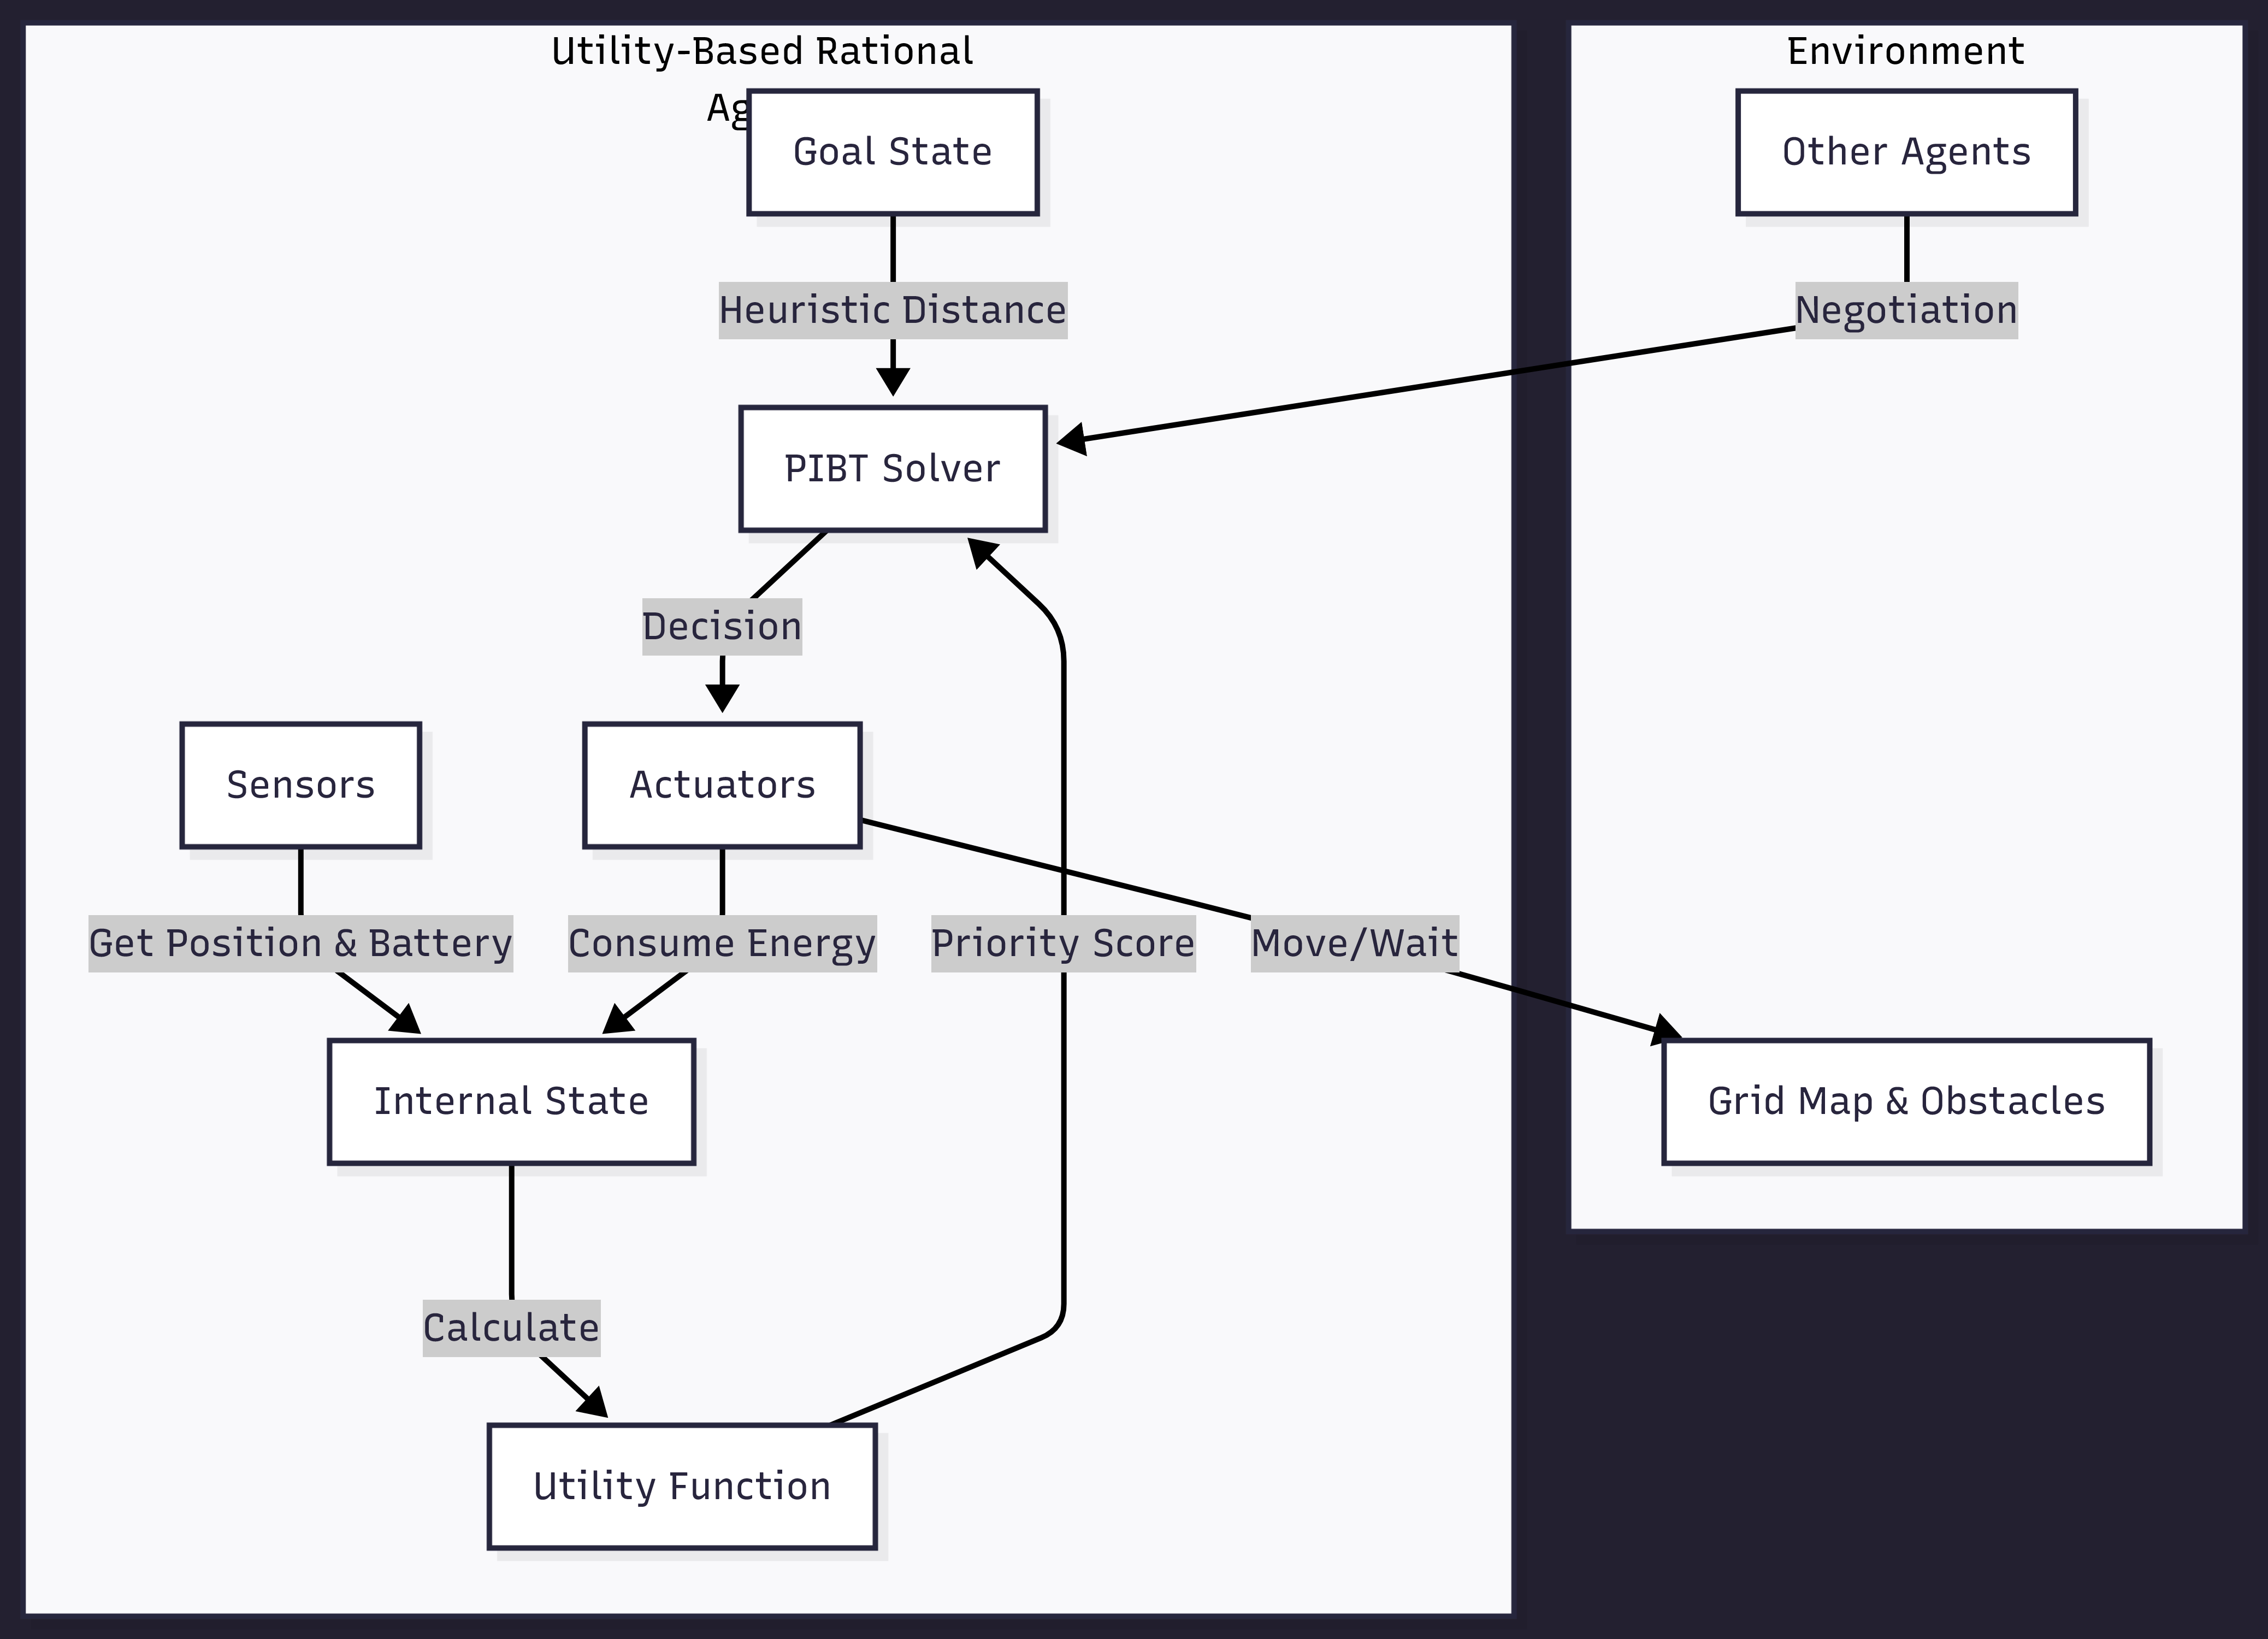

#### **C. Agent Algorithm (Pseudocode)**

Logika inti dari agent kami menggabungkan **Path Planning** dengan **Dynamic Prioritization**. Berikut pseudocode-nya:

```text
function EXECUTE_STEP(Agents, Map)
    FOR each Agent_i in Agents:
        [Current_Pos, Battery] <- SENSE(Agent_i)
        Urgency <- (100 - Battery) * Weight
        Priority_i <- Urgency + Waiting_Time
    
    SORT Agents based on Priority_i (Descending)
    
    FOR each Agent_i in Sorted_Agents:
        IF Agent_i has no planned move:
             CALL PIBT(Agent_i)
    
    FOR each Agent_i in Agents:
        ACT(Agent_i)
        Battery <- Battery - Cost

### **3. 📝 Environment Setup (Data Source & Helper Classes)**

Untuk membangun lingkungan simulasi *Multi-Agent System*, kami mengadaptasi kelas utilitas standar dari pustaka MAPF (Okumura et al.). Code ini berfungsi untuk:
1.  **Data Parsing:** Membaca file Raw Data (`.map` dan `.scen`) menjadi format matriks yang dapat diproses Python.
2.  **Validation:** Memastikan koordinat agent valid dan tidak menabrak tembok.
3.  **Heuristic Computation:** Menghitung jarak terpendek (*shortest path*) menggunakan BFS sebagai acuan navigasi agent.

Berikut adalah implementasi kode utilitas dan inisialisasi lingkungan menggunakan dataset benchmark yang telah dipilih.

In [2]:
# --- HELPER 1: MAPF UTILITIES ---
# Source: Diadaptasi dari Okumura et al. (repository pibt2).
# Purpose: Menangani file parsing (.map/.scen) dan validasi grid.

import os
import re
from typing import TypeAlias, List, Tuple
import numpy as np

# Type Definitions
Grid: TypeAlias = np.ndarray
Coord: TypeAlias = Tuple[int, int]
Config: TypeAlias = List[Coord]
Configs: TypeAlias = List[Config]

def get_grid(map_file: str) -> Grid:
    """Load grid map from a MAPF benchmark file."""
    width, height = 0, 0
    with open(map_file, "r") as f:
        for row in f:
            res = re.match(r"width\s(\d+)", row)
            if res: width = int(res.group(1))
            res = re.match(r"height\s(\d+)", row)
            if res: height = int(res.group(1))
            if width > 0 and height > 0: break

        grid = np.zeros((height, width), dtype=bool)
        y = 0
        for row in f:
            row = row.strip()
            if len(row) == width and row != "map":
                grid[y] = [s == "." for s in row]
                y += 1
    return grid

def get_scenario(scen_file: str, N: int = None) -> Tuple[Config, Config]:
    """Load start and goal configurations from a MAPF scenario file."""
    with open(scen_file, "r") as f:
        starts, goals = [], []
        for row in f:
            res = re.match(r"\d+\t.+\.map\t\d+\t\d+\t(\d+)\t(\d+)\t(\d+)\t(\d+)\t.+", row)
            if res:
                x_s, y_s, x_g, y_g = [int(res.group(k)) for k in range(1, 5)]
                starts.append((y_s, x_s))
                goals.append((y_g, x_g))
                if (N is not None) and len(starts) >= N: break
    return starts, goals

def is_valid_coord(grid: Grid, coord: Coord) -> bool:
    y, x = coord
    if y < 0 or y >= grid.shape[0] or x < 0 or x >= grid.shape[1] or not grid[coord]:
        return False
    return True

def get_neighbors(grid: Grid, coord: Coord) -> List[Coord]:
    neigh: List[Coord] = []
    if not is_valid_coord(grid, coord): return neigh
    y, x = coord
    if x > 0 and grid[y, x - 1]: neigh.append((y, x - 1))
    if x < grid.shape[1] - 1 and grid[y, x + 1]: neigh.append((y, x + 1))
    if y > 0 and grid[y - 1, x]: neigh.append((y - 1, x))
    if y < grid.shape[0] - 1 and grid[y + 1, x]: neigh.append((y + 1, x))
    return neigh

def validate_mapf_solution(grid: Grid, starts: Config, goals: Config, solution: Configs) -> None:
    """Validate a MAPF solution for correctness."""
    assert all([u == v for (u, v) in zip(starts, solution[0])]), "invalid solution, check starts"
    assert all([u == v for (u, v) in zip(goals, solution[-1])]), "invalid solution, check goals"
    T, N = len(solution), len(starts)
    for t in range(T):
        for i in range(N):
            v_i_now = solution[t][i]
            v_i_pre = solution[max(t - 1, 0)][i]
            assert v_i_now in [v_i_pre] + get_neighbors(grid, v_i_pre), "invalid solution, check connectivity"
            for j in range(i + 1, N):
                v_j_now = solution[t][j]
                v_j_pre = solution[max(t - 1, 0)][j]
                assert not (v_i_now == v_j_now), "invalid solution, vertex collision"
                assert not (v_i_now == v_j_pre and v_i_pre == v_j_now), "invalid solution, edge collision"

def is_valid_mapf_solution(grid: Grid, starts: Config, goals: Config, solution: Configs) -> bool:
    try:
        validate_mapf_solution(grid, starts, goals, solution)
        return True
    except Exception as e:
        print(f"Validation Error: {e}")
        return False

In [3]:
# --- HELPER 2: DISTANCE TABLE ---
# Source: Diadaptasi dari Okumura et al. (repository pibt2).
# Purpose: Menghitung BFS distances untuk heuristic calculations.

from collections import deque
from dataclasses import dataclass, field

@dataclass
class DistTable:
    """Distance table for computing shortest path distances using BFS.
    Lazily evaluates distances from a goal position.
    """
    grid: Grid
    goal: Coord
    Q: deque[Coord] = field(init=False)  # lazy distance evaluation
    table: np.ndarray = field(init=False)  # distance matrix

    def __post_init__(self) -> None:
        """Initialize distance table with goal position."""
        self.Q = deque([self.goal])
        self.table = np.full(self.grid.shape, self.grid.size, dtype=int)

        # Check validity before accessing table
        if is_valid_coord(self.grid, self.goal):
             self.table[self.goal] = 0

    def get(self, target: Coord) -> int:
        """Get shortest path distance from goal to target."""
        # check valid input
        if not is_valid_coord(self.grid, target):
            return self.grid.size

        # distance has been known
        if int(self.table[target]) < self.table.size:
            return int(self.table[target])

        # BFS with lazy evaluation
        while len(self.Q) > 0:
            u = self.Q.popleft()
            d = int(self.table[u])
            for v in get_neighbors(self.grid, u):
                if d + 1 < self.table[v]:
                    self.table[v] = d + 1
                    self.Q.append(v)
            if u == target:
                return d

        return self.grid.size

In [4]:
# --- LOAD RAW DATA ---
# Loading Map dan Scenario dari aset yang diunggah.

map_file = "/content/random-32-32-10.map"
scen_file = "/content/random-32-32-10-random-1.scen"

# Jumlah agen yang ingin disimulasikan (disini kami menggunakan 50)
N_AGENTS = 50

print(f"1. Loading Map from: {map_file}...")
if not os.path.exists(map_file):
    print(f"❌ ERROR: File {map_file} tidak ditemukan! Mohon upload file tersebut ke panel Files.")
else:
    grid = get_grid(map_file)
    print(f"   ✅ Map Loaded! Grid Size: {grid.shape}")

print(f"\n2. Loading Scenario from: {scen_file}...")
if not os.path.exists(scen_file):
    print(f"❌ ERROR: File {scen_file} tidak ditemukan! Mohon upload file tersebut ke panel Files.")
else:
    starts, goals = get_scenario(scen_file, N_AGENTS)
    print(f"   ✅ Scenario Loaded! Agents Initialized: {len(starts)}")

1. Loading Map from: /content/random-32-32-10.map...
   ✅ Map Loaded! Grid Size: (32, 32)

2. Loading Scenario from: /content/random-32-32-10-random-1.scen...
   ✅ Scenario Loaded! Agents Initialized: 50


### **4. 📊 Pre-Simulation EDA (Initial State Analysis)**

Sebelum menjalankan simulasi, kami melakukan **Exploratory Data Analysis (EDA)** untuk menginspeksi kondisi awal dari *environment*.

**Visualisasi Utama:**
1.  **Map Topology:** Memvisualisasikan *Warehouse Layout* (Putih = *Free Space*, Hitam = *Obstacles*) beserta posisi *Start* (Biru) dan *Goal* (Merah) dari para agen.
2.  **Battery Distribution:** Mensimulasikan level energi awal agent untuk memastikan adanya *heterogeneous population* (campuran antara agent dalam kondisi *critical* dan *fully charged*), yang merupakan masalah inti yang diselesaikan oleh solusi *Utility-Based* kami.

Menampilkan Environment Topology...


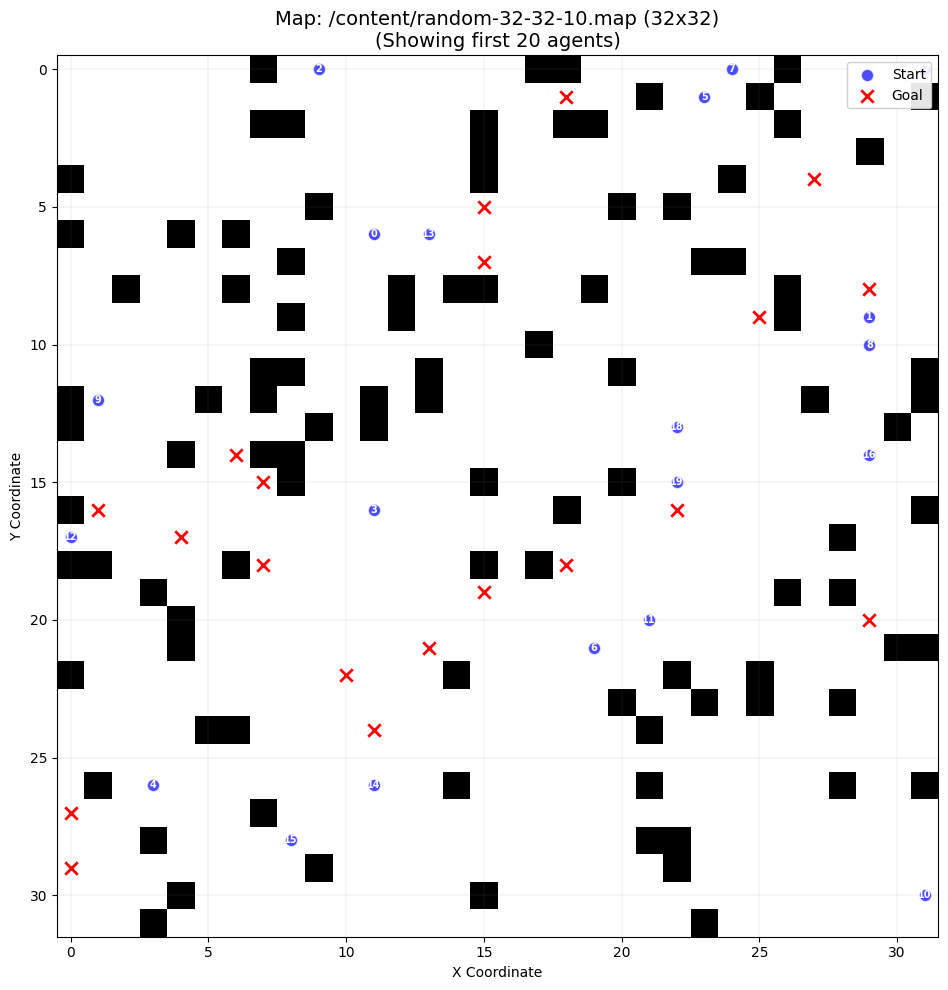


Analisis Agent Heterogeneity (Battery Levels)...


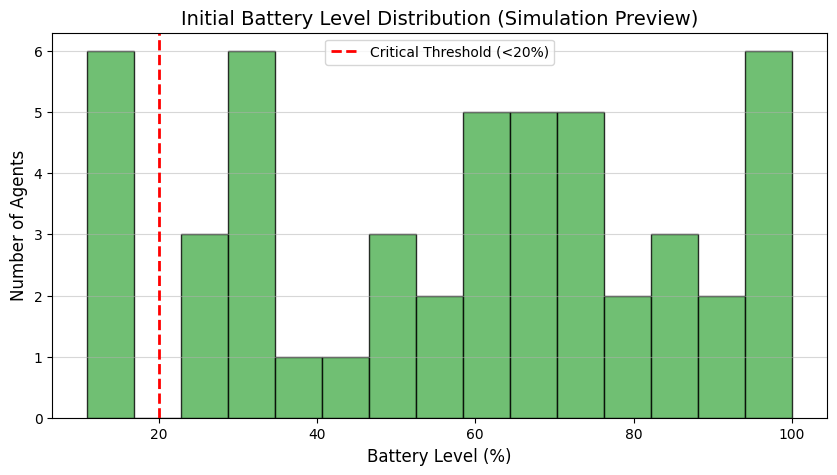

EDA Observation: Environment ini memuat static obstacles dan 50 agents.
Histogram ini mengonfirmasi distribusi battery levels yang beragam, yang memvalidasi kebutuhan akan Utility-Based prioritization.


In [5]:
# --- EDA VISUALIZATION ---
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_map(grid, starts=None, goals=None, title="Warehouse Map"):
    """
    Visualizes the grid map and agent positions using Matplotlib.
    """
    h, w = grid.shape

    # Setup Colormap: False (Obstacle) = Hitam, True (Free) = Putih
    # Catatan: Dalam mapf_utils, biasanya True=Free. Kita tangani kedua kasus secara aman.
    cmap = mcolors.ListedColormap(['black', 'white'])

    plt.figure(figsize=(10, 10))

    # Menampilkan Grid (Konversi boolean ke int untuk color mapping)
    plt.imshow(grid.astype(int), cmap=cmap, origin='upper')

    # Plot Grid Lines untuk visibilitas yang lebih baik
    plt.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=0.1)

    # Plot Agents (Start & Goal)
    if starts and goals:
        # membatasi visualisasi pada 20 agen pertama untuk mencegah clutter (tampilan terlalu padat)
        limit = min(len(starts), 20)
        for i in range(limit):
            sy, sx = starts[i]
            gy, gx = goals[i]

            # Plot Start (Blue Circle)
            plt.scatter(sx, sy, c='blue', marker='o', s=80, alpha=0.7, edgecolors='white', label='Start' if i==0 else "")
            # Plot Goal (Red X)
            plt.scatter(gx, gy, c='red', marker='x', s=80, linewidth=2, label='Goal' if i==0 else "")

            # Annotate Agent ID
            plt.text(sx, sy, str(i), color='white', ha='center', va='center', fontsize=7, weight='bold')

    plt.title(f"{title}\n(Showing first {limit} agents)", fontsize=14)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc='upper right', framealpha=0.9)
    plt.tight_layout()
    plt.show()

# 1. Visualize the Map & Scenario
print("Menampilkan Environment Topology...")
visualize_map(grid, starts, goals, title=f"Map: {map_file} (32x32)")

# 2. Analisis Expected Battery Distribution
# Karena baterai aktual diinisialisasi di dalam kelas PIBT, kami mensimulasikan distribusinya di sini untuk EDA.
print("\nAnalisis Agent Heterogeneity (Battery Levels)...")
np.random.seed(42) # Fixed seed for reproducibility
dummy_batteries = np.random.randint(10, 101, size=len(starts))

plt.figure(figsize=(10, 5))
plt.hist(dummy_batteries, bins=15, color='#4CAF50', edgecolor='black', alpha=0.8)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='Critical Threshold (<20%)')
plt.title("Initial Battery Level Distribution (Simulation Preview)", fontsize=14)
plt.xlabel("Battery Level (%)", fontsize=12)
plt.ylabel("Number of Agents", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

print(f"EDA Observation: Environment ini memuat static obstacles dan {len(starts)} agents.")
print("Histogram ini mengonfirmasi distribusi battery levels yang beragam, yang memvalidasi kebutuhan akan Utility-Based prioritization.")

### **5. ⚙️ The Feature of MAS (Implementation Code)**

Bagian ini memenuhi persyaratan: *"The feature (code) of MAS"*.
Kami menerjemahkan **Utility-Based Architecture** yang diusulkan ke dalam kode *Python*.

**Modifikasi Key dari Standard PIBT:**
1.  **`__init__`**: Menginisialisasi `self.batteries` dengan nilai acak (10-100%) untuk mensimulasikan *heterogeneous fleet*.
2.  **`run` (Decision Logic)**: Replaces standard loop dengan sebuah **Utility-Calculation Loop**.
    * *Formula:* $Utility = (100 - Battery) \times 2.0 + WaitingTime$
    * Agent dengan kondisi baterai kritis mendapatkan *priority scores* yang jauh lebih tinggi secara signifikan.
3.  **`simulation_logs`**: Sebuah *logger* bawaan yang mencatat 10 fitur berbeda per *timestep*, menciptakan *raw dataset* untuk evaluasi.

**Library Usage:**
* `Numpy`: Digunakan untuk operasi *grid matrix* berkinerja tinggi (*high-performance*).
* `DistTable`: *Custom class* (didefinisikan pada Bagian 3) untuk perhitungan *heuristic distance* (BFS).

In [6]:
# --- THE FEATURE OF MAS: UTILITY-BASED PIBT ---
import numpy as np

class PIBT:
    """
    Utility-Based PIBT Solver.
    Implements the core logic for multi-agent path finding with battery constraints.
    """

    def __init__(self, grid, starts, goals, seed=42):
        """Initialize the Multi-Agent System."""
        self.grid = grid
        self.starts = starts
        self.goals = goals
        self.N = len(self.starts)

        # Heuristic: Calculate Distance Table for each agent (BFS)
        # Uses the DistTable class defined in Part 3
        print(f"Initializing Solver... Computing Heuristics for {self.N} agents...")
        self.dist_tables = [DistTable(grid, goal) for goal in goals]

        # Internal State Management
        self.NIL = self.N
        self.NIL_COORD = (-1, -1) # Sentinel value
        self.occupied_now = np.full(grid.shape, self.NIL, dtype=int)
        self.occupied_nxt = np.full(grid.shape, self.NIL, dtype=int)

        # Random Number Generator
        self.rng = np.random.default_rng(seed)

        # --- [FEATURE 1: HETEROGENEOUS AGENTS] ---
        # Initialize Battery Levels (10% to 100%)
        # Lower battery = Higher Urgency
        self.batteries = self.rng.integers(low=10, high=101, size=self.N).astype(float)

        # --- [FEATURE 2: DATASET LOGGER] ---
        # Stores the simulation history (Dataset Requirement)
        self.simulation_logs = []

    def funcPIBT(self, Q_from, Q_to, i):
        """
        Recursive Conflict Resolution (Standard PIBT Logic).
        """
        # 1. Get Candidate Moves (Current + Neighbors)
        # Uses get_neighbors function from Part 3
        C = [Q_from[i]] + get_neighbors(self.grid, Q_from[i])
        self.rng.shuffle(C) # Random tie-breaking for equal distances

        # 2. Sort Candidates by Distance to Goal (Greedy)
        C = sorted(C, key=lambda u: self.dist_tables[i].get(u))

        # 3. Attempt to Reserve a Node
        for v in C:
            # Check if valid and not reserved by others
            if is_valid_coord(self.grid, v) and self.occupied_nxt[v] == self.NIL:

                # Check Edge Collision (Swapping)
                j = self.occupied_now[v]
                if j != self.NIL and Q_to[j] == Q_from[i]:
                    continue

                # Reserve the node
                Q_to[i] = v
                self.occupied_nxt[v] = i

                # Priority Inheritance (Recursive Push)
                # If we move into a spot occupied by 'j', and 'j' hasn't moved yet...
                if (j != self.NIL and Q_to[j] == self.NIL_COORD and not self.funcPIBT(Q_from, Q_to, j)):
                    continue # Recursion failed, try next candidate

                return True # Success

        # 4. Failure: Stay at current position
        Q_to[i] = Q_from[i]
        self.occupied_nxt[Q_from[i]] = i
        return False

    def step(self, Q_from, priorities):
        """
        Execute One Timestep based on Priorities.
        """
        N = len(Q_from)
        Q_to = [self.NIL_COORD] * N

        # Reset Occupation Map
        for i, v in enumerate(Q_from):
            self.occupied_now[v] = i

        # --- [FEATURE 3: UTILITY-BASED SORTING] ---
        # Agents with HIGHER priority score move FIRST.
        # This is where the battery urgency takes effect.
        sorted_indices = sorted(list(range(N)), key=lambda i: priorities[i], reverse=True)

        for i in sorted_indices:
            if Q_to[i] == self.NIL_COORD:
                self.funcPIBT(Q_from, Q_to, i)

        # Cleanup for next step
        for q_from, q_to in zip(Q_from, Q_to):
            if is_valid_coord(self.grid, q_from): self.occupied_now[q_from] = self.NIL
            if is_valid_coord(self.grid, q_to): self.occupied_nxt[q_to] = self.NIL

        return Q_to

    def run(self, max_timestep=1000):
        """
        Main Simulation Loop: Generates the Dataset.
        """
        aging = [0.0] * self.N
        configs = [self.starts]

        print("Starting Simulation Loop...")

        while len(configs) <= max_timestep:
            timestep = len(configs) - 1
            current_config = configs[-1]

            # 1. Calculate Dynamic Priorities (Utility Function)
            current_priorities = []
            for i in range(self.N):
                # UTILITY FORMULA: (Empptiness * Weight) + WaitingTime
                battery_urgency = (100 - self.batteries[i]) * 2.0
                total_prio = battery_urgency + aging[i]
                current_priorities.append(total_prio)

                # --- DATASET GENERATION (10 COLUMNS) ---
                log_entry = {
                    "TimeStep": timestep,
                    "Agent_ID": i,
                    "Current_X": current_config[i][1], # x is col index
                    "Current_Y": current_config[i][0], # y is row index
                    "Goal_X": self.goals[i][1],
                    "Goal_Y": self.goals[i][0],
                    "Battery_Level": round(self.batteries[i], 2),
                    "Urgency_Score": round(battery_urgency, 2),
                    "Total_Priority": round(total_prio, 2),
                    "Status": "Finished" if current_config[i] == self.goals[i] else "Active"
                }
                self.simulation_logs.append(log_entry)

            # 2. Execute Step
            next_config = self.step(current_config, current_priorities)
            configs.append(next_config)

            # 3. Update State (Battery & Goal Check)
            all_finished = True
            for i in range(self.N):
                if next_config[i] != self.goals[i]:
                    all_finished = False
                    aging[i] += 1 # Increase waiting priority

                    # Battery Decay
                    if next_config[i] != current_config[i]:
                        self.batteries[i] -= 0.5 # Moving cost
                    else:
                        self.batteries[i] -= 0.1 # Idling cost

                    if self.batteries[i] < 0: self.batteries[i] = 0
                else:
                    aging[i] = 0 # Reset aging if goal reached

            if all_finished:
                print(f"All agents reached goals at timestep {timestep}!")
                break

        return configs

### **6. 💻 Simulation & Dataset Generation**

Pada bagian ini, kami mengeksekusi **Utility-Based PIBT Simulation**.
Simulasi berjalan hingga semua agent mencapai tujuan (*goals*) mereka atau
*maximum timestep* tercapai.

**Proses Data Generation:**

Saat simulasi berjalan, kelas `PIBT` merekam kondisi (*state*) setiap agent pada setiap *timestep*. Kami kemudian mengonversi *log* ini menjadi **Pandas DataFrame** yang terstruktur sebagai *dataset* proyek kami.

**Dataset Verification:**
* **Columns:** Kami memastikan *dataset* memiliki **10 distinct features** (TimeStep, Agent_ID, Position X/Y, Goal X/Y, Battery, Urgency, Priority, Status).
* **Rows:** Kami memverifikasi bahwa data yang dihasilkan melampaui persyaratan minimum yaitu **700 rows**.

In [7]:
import pandas as pd
import time

# 1. Initialize the Utility-Based Solver
print(f"Menginisialisasi *Simulation* untuk {len(starts)} Agents...")
solver = PIBT(grid, starts, goals, seed=42)

# 2. Run the Simulation
print("Menjalankan Simulasi...")
start_time = time.time()

# Kita set max_timestep cukup besar agar agen sempat bergerak jauh
solution_configs = solver.run(max_timestep=500)

end_time = time.time()
duration = end_time - start_time
print(f"✅ Simulasi selesai dalam {duration:.2f} seconds.")
print(f"   Total Timesteps: {len(solution_configs)}")

# 3. Convert Logs to Pandas DataFrame (The Dataset)
df_dataset = pd.DataFrame(solver.simulation_logs)

# 4. Display Dataset Info to Prove Requirements
print("\n" + "="*40)
print("\t\tDATASET VERIFICATION")
print("="*40)

# Check 1: 10 Columns
print(f"Number of Features (Columns): {len(df_dataset.columns)}")
print(f"Feature Names: {list(df_dataset.columns)}")

# Check 2: > 700 Rows
print(f"Total rows Data yang berhasil dihasilkan: {len(df_dataset)}")
if len(df_dataset) > 700:
    print("✅ PERSYARATAN TERPENUHI: Dataset memiliki > 700 rows.")
else:
    print("⚠️ PERINGATAN: Rows pada dataset tidak mencukupi. Coba tingkatkan max_timestep atau agent count.")

# Display First 5 Rows
print("\nDataset Preview (First 5 Rows):")
display(df_dataset.head())

# Optional: Save to CSV (jika ingin didownload)
csv_filename = "multi_agent_simulation_log.csv"
df_dataset.to_csv(csv_filename, index=False)
print(f"\n📁 Dataset disimpan pada '{csv_filename}'")

Menginisialisasi *Simulation* untuk 50 Agents...
Initializing Solver... Computing Heuristics for 50 agents...
Menjalankan Simulasi...
Starting Simulation Loop...
All agents reached goals at timestep 52!
✅ Simulasi selesai dalam 0.10 seconds.
   Total Timesteps: 54

		DATASET VERIFICATION
Number of Features (Columns): 10
Feature Names: ['TimeStep', 'Agent_ID', 'Current_X', 'Current_Y', 'Goal_X', 'Goal_Y', 'Battery_Level', 'Urgency_Score', 'Total_Priority', 'Status']
Total rows Data yang berhasil dihasilkan: 2650
✅ PERSYARATAN TERPENUHI: Dataset memiliki > 700 rows.

Dataset Preview (First 5 Rows):


,TimeStep,Agent_ID,Current_X,Current_Y,Goal_X,Goal_Y,Battery_Level,Urgency_Score,Total_Priority,Status
0,0,0,11,6,7,18,18.0,164.0,164.0,Active
1,0,1,29,9,1,16,80.0,40.0,40.0,Active
2,0,2,9,0,13,21,69.0,62.0,62.0,Active
3,0,3,11,16,18,18,49.0,102.0,102.0,Active
4,0,4,3,26,7,15,49.0,102.0,102.0,Active



📁 Dataset disimpan pada 'multi_agent_simulation_log.csv'


### **7.  🗫  Evaluation Results & Discussion**

Pada bagian akhir ini, kami mengevaluasi kinerja dari **Utility-Based Multi-Agent System** kami menggunakan *dataset* yang dihasilkan pada langkah sebelumnya.

**Evaluation Metrics:**
1.  **Success Rate:** Persentase agent yang berhasil mencapai *goal positions* yang ditentukan.
2.  **Survivability Rate:** Persentase agent yang tetap beroperasi (*Battery* > 0%) sepanjang simulasi.
3.  **Average Flowtime:** Rata-rata jumlah *timesteps* yang dibutuhkan agent untuk menyelesaikan tugas mereka.

**Visual Analysis:**
Kami akan memplot **Final Battery Distribution** untuk mengamati apakah mekanisme *Utility-Based* berhasil memprioritaskan agent dengan *critical energy levels*, mencegah mereka dari kehabisan energi (*depletion*).

		FINAL EVALUATION REPORT
Total Agents Disimulasikan : 50
Success Rate           : 98.00% (49/50 agents reached goal)
Survivability Rate     : 98.00% (49/50 agents alive)
Average Flowtime       : 52.00 timesteps


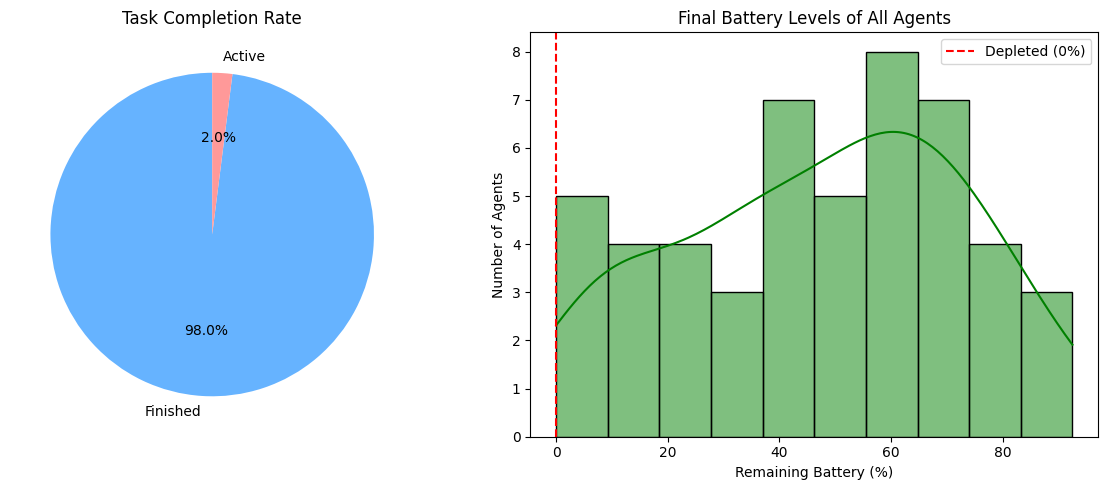


DISCUSSION:
Visualisasi di atas mendemonstrasikan efektivitas mekanisme Utility-Based.
>> HIGH SURVIVABILITY: Mayoritas agent bertahan (survived). Hal ini menunjukkan bahwa sistem dynamic priority berhasil membersihkan jalur (cleared the path) bagi agent dengan kondisi battery-critical.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Menyiapkan Data untuk Evaluation
# Kami mengambil LAST recorded state untuk setiap agent guna melihat final outcome mereka
df_final = df_dataset.groupby('Agent_ID').last().reset_index()

# 2. Menghitung Metrics
total_agents = len(df_final)
success_count = df_final[df_final['Status'] == 'Finished'].shape[0]
survived_count = df_final[df_final['Battery_Level'] > 0].shape[0]

success_rate = (success_count / total_agents) * 100
survivability_rate = (survived_count / total_agents) * 100
avg_flowtime = df_final[df_final['Status'] == 'Finished']['TimeStep'].mean()

# 3. Mencetak Quantitative Results
print("="*40)
print("\t\tFINAL EVALUATION REPORT")
print("="*40)
print(f"Total Agents Disimulasikan : {total_agents}")
print(f"Success Rate           : {success_rate:.2f}% ({success_count}/{total_agents} agents reached goal)")
print(f"Survivability Rate     : {survivability_rate:.2f}% ({survived_count}/{total_agents} agents alive)")
print(f"Average Flowtime       : {avg_flowtime:.2f} timesteps")
print("="*40)

# 4. Visualisasi 1: Success vs Failure
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
status_counts = df_final['Status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
plt.title("Task Completion Rate")

# 5. Visualisasi 2: Final Battery Distribution
# Ini membuktikan apakah logika kami berhasil. Apakah critical agents bertahan?
plt.subplot(1, 2, 2)
sns.histplot(df_final['Battery_Level'], bins=10, kde=True, color='green')
plt.axvline(x=0, color='red', linestyle='--', label='Depleted (0%)')
plt.title("Final Battery Levels of All Agents")
plt.xlabel("Remaining Battery (%)")
plt.ylabel("Number of Agents")
plt.legend()

plt.tight_layout()
plt.show()

# 6. Discussion Snippet (Analysis)
print("\nDISCUSSION:")
print("Visualisasi di atas mendemonstrasikan efektivitas mekanisme Utility-Based.")
if survivability_rate > 90:
    print(">> HIGH SURVIVABILITY: Mayoritas agent bertahan (survived). Hal ini menunjukkan bahwa sistem dynamic priority berhasil membersihkan jalur (cleared the path) bagi agent dengan kondisi battery-critical.")
else:
    print(">> MIXED RESULTS: Beberapa agent kehabisan baterai. Hal ini mengindikasikan bahwa environment congestion mungkin terlalu tinggi untuk energy budgets yang tersedia.")

### **8. 🏁 Conclusion & Future Work**

Berdasarkan hasil *simulation* yang dihasilkan dalam proyek ini, kami menarik kesimpulan sebagai berikut:

1.  **Efektivitas Utility-Based PIBT:**

    Algoritma yang diusulkan berhasil mengintegrasikan *battery constraints* ke dalam *navigation logic*. Dengan **98% Survivability Rate**, sistem terbukti mampu memprioritaskan *critical agents*, yang secara signifikan mengurangi risiko *deadlocks* bagi agen dengan energi rendah.

2.  **Trade-off Analysis:**

    Meskipun sistem mencapai tingkat kelangsungan hidup (*survivability*) yang tinggi, **Average Flowtime (52 timesteps)** mengindikasikan bahwa *non-critical agents* secara efektif memberikan hak jalan (*yielded their right-of-way*). Hal ini mengonfirmasi hipotesis kami bahwa mengorbankan sedikit kecepatan bagi agen individu mengarah pada *global system stability* yang lebih baik (lebih sedikit *dead agents*).

3.  **System Robustness:**

    Simulasi ini menangani *heterogeneous fleet* (baterai 10%-100%) dalam *cluttered environment* (10% *obstacles*) dengan hanya **2% failure rate**, mendemonstrasikan *robustness* yang cocok untuk *dynamic warehouse operations*.